In [1]:
import sys
print sys.prefix
print sys.version

c:\anaconda2\envs\mypy
2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


## Import custom modules and create the DrillQueries singleton

In [2]:
import aphp_waves_dic as wd
import drill_utilities as du
import drill_queries as dq

drill_q = dq.DrillQueries("drill_eds", ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2'])

In [ ]:
# drop/create temporary tables
drill_q.drop_table("icu_nda_mouv_ufr_tr")
drill_q.create_icu_nda_mouv_ufr_tr()
drill_q.drop_table("icu_sensor_24")
drill_q.create_icu_sensor_24()
drill_q.drop_table("icu_pat_info")
drill_q.create_icu_pat_info()

In [4]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Number of measures by type (first 24h in ICU)

In [5]:
df_mes = drill_q.drill_conn.df_from_query(drill_q.queries['QUERY_MEASURES_COUNTERS'])
df_mes.head(10)

,counter,id_measure_type,label
0,246490,10102,Frquence cardiaque
1,243159,10168,Saturation pulse Oxygne
2,237342,10120,Frequence respiratoire
3,191174,10121,Mode Ventilatoire
4,146710,11,Pression artrielle non invasive systolique
5,145689,12,Pression artrielle non invasive diastolique
6,142949,13,Pression artrielle non invasive moyenne
7,140900,10281,MEGS PAS Intervalle 2h
8,140433,10282,MEGS PAM intervalle 2h
9,140124,10283,MEGS PAD intervalle 2h


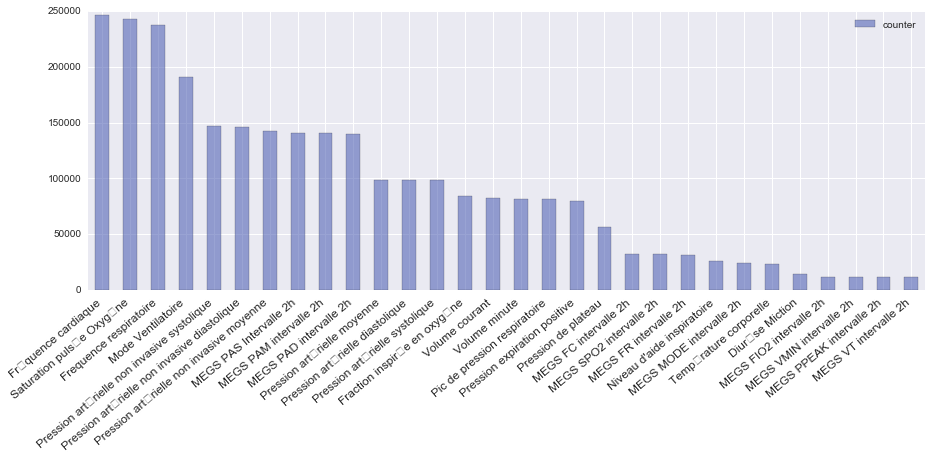

In [6]:
ax = df_mes[['counter', 'label']].head(30).plot(kind = 'bar', color = '#5566b7', alpha=0.6, figsize=(15, 5));
ax.set_xticklabels(df_mes['label'].str.decode('utf8'), rotation=40, fontsize=12, ha='right');

## sample time bounds

In [7]:
drill_q.drill_conn.df_from_query("select min(dt_deb) as begining, max(dt_deb) as ending from icu_sensor_24")

,begining,ending
0,2012-09-05,2016-05-17


## Counting measures by cases

In [8]:
counter_matrix = drill_q.get_counter_matrix()
print "Total number of cases for first 24h on ICUs: ", len(counter_matrix)

Total number of cases for first 24h on ICUs:  3706


In [9]:
counter_matrix.head(3)

id_measure_type,11,12,14,15,10102,10120,10168,10280,10281,10283,10285,10291
id_ndaj1,,,,,,,,,,,,
27445892014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,96.0,11.0,71.0,70.0,11.0,11.0
27445892014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,96.0,12.0,12.0,12.0,12.0,12.0
27542662014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,82.0,12.0,12.0,12.0,10.0,12.0


## Filter when one of the VOI is not defined
VOI = Variable of Interest

In [10]:
counter_matrix = drill_q.case_first_level_filter(counter_matrix)
print("Number of cases for first 24h having values for {}: {}".format(drill_q._voi, len(counter_matrix)))

Number of cases for first 24h having values for ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2']: 3190


## Filter when one of the VOIs have less than 6 points

In [11]:
counter_matrix = drill_q.case_second_level_filter(counter_matrix, 6)
print("Number of cases for first 24h having at least 6 values for {}: {}".format(drill_q._voi, len(counter_matrix)))

Number of cases for first 24h having at least 6 values for ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2']: 2951


## Filter for patients having less than 15

In [12]:
demographic_df = drill_q.get_cases_data()
c_matrix = drill_q.case_more_age_filter(counter_matrix, demographic_df, age_min=15)
print("Number of cases for first 24h having at least 6 values for {} and more than 15 years old: {}"
      .format(drill_q.voi, len(c_matrix)))

Number of cases for first 24h having at least 6 values for ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2'] and more than 15 years old: 2948


In [13]:
c_matrix.head(2)

id_measure_type,11,12,14,15,10102,10120,10168,10280,10281,10283,10285,10291,age,dt_deces
id_ndaj1,,,,,,,,,,,,,,
95956472016-04-06,9.0,9.0,66.0,66.0,66.0,66.0,66.0,9.0,9.0,9.0,9.0,9.0,80.309377,2016-04-07 20:06:00
95761232016-04-04,70.0,70.0,0.0,0.0,65.0,65.0,65.0,9.0,69.0,69.0,9.0,9.0,48.487337,NaT


## Mortality rate at this stage

In [14]:
mr = float(c_matrix[c_matrix['dt_deces'].notnull()].shape[0]) / float(c_matrix.shape[0]) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 22.2184531886


## Look for number of patients stayed more than 20h

In [15]:
c_stay_more_20h = drill_q.case_filter_by_stay_interval(c_matrix, interval_min=20)
print("Number of cases for first 24h having at least 6 values for {} and more than 15 years old".format(drill_q.voi))
print("and stayed at least 20 hours: {}".format(len(c_stay_more_20h)))

Number of cases for first 24h having at least 6 values for ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2'] and more than 15 years old
and stayed at least 20 hours: 2098


## Filter by stay length

In [16]:
c_matrix = drill_q.case_filter_by_stay_interval(c_matrix, interval_min=3)
print("Number of cases for first 24h having at least 6 values for {} and more than 15 years old".format(drill_q.voi))
print("and stayed at least 3 hours: {}".format(len(c_matrix)))

Number of cases for first 24h having at least 6 values for ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2'] and more than 15 years old
and stayed at least 3 hours: 2876


## Mortality rate at this stage

In [17]:
mr = float(c_matrix[c_matrix['dt_deces'].notnull()].shape[0]) / float(c_matrix.shape[0]) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 21.9401947149


In [18]:
for v in drill_q.voi:
    aphp_codes = drill_q._dic.get_all_voi_codes([v])
    c_matrix_v = c_matrix[aphp_codes]
    c_matrix[v] = c_matrix_v.sum(axis=1)
c_matrix.head(2)

id_measure_type,11,12,14,15,10102,10120,10168,10280,10281,10283,...,age,dt_deces,dt_min,dt_max,stay_len,HR,RR,ABPS,ABPD,SPO2
id_ndaj1,,,,,,,,,,,,,,,,,,,,,
27445892014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,96.0,11.0,71.0,70.0,...,62.171116,2014-08-04 05:33:00,2014-05-08 00:44:00,2014-05-09 00:21:01,23:37:01,108.0,107.0,179.0,177.0,107.0
27445892014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,96.0,12.0,12.0,12.0,...,62.171116,2014-08-04 05:33:00,2014-06-24 19:13:09,2014-06-25 18:46:02,23:32:53,108.0,108.0,133.0,133.0,108.0


## Number of measures per VOI and age structure of the dataset

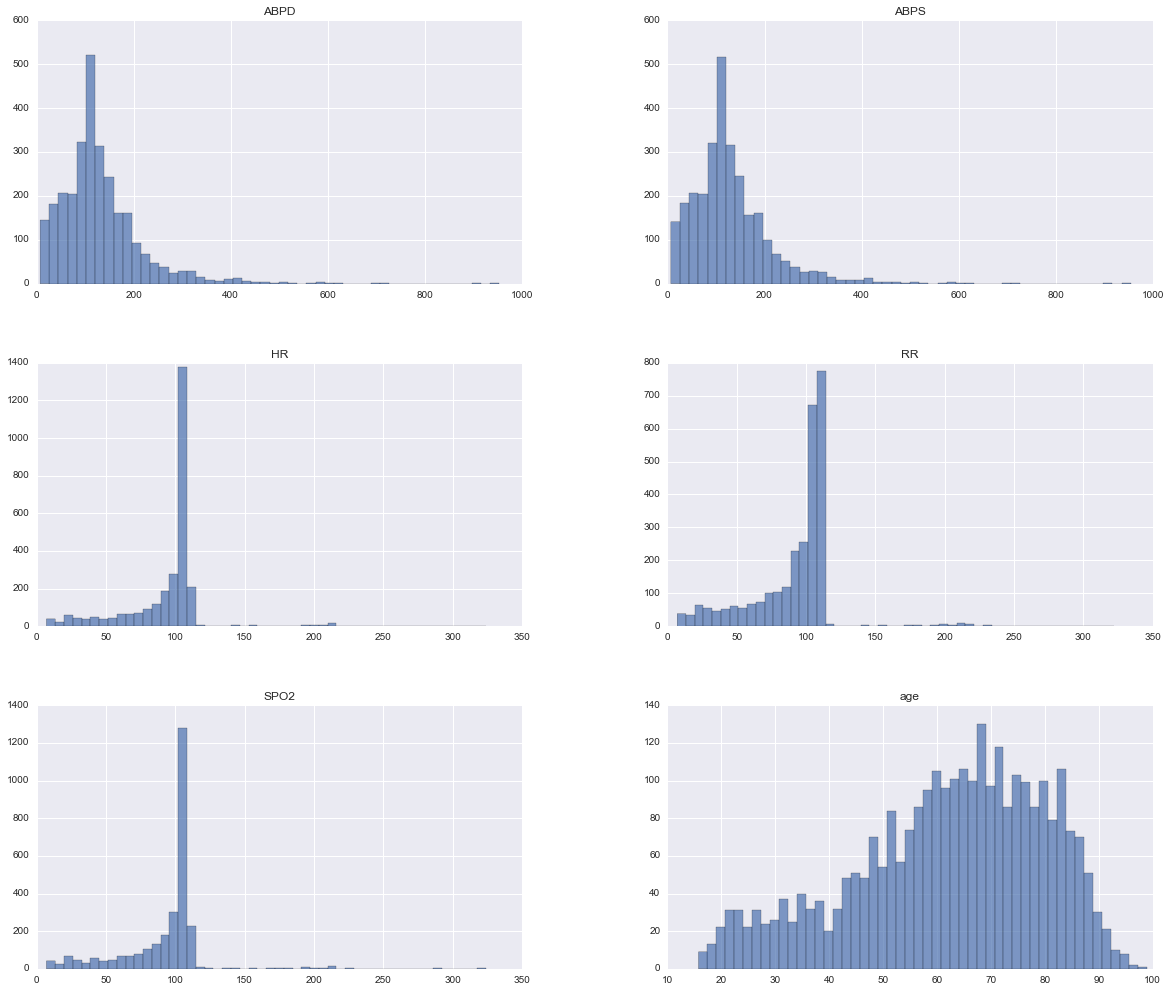

In [19]:
l = list(drill_q.voi)
l.append('age')
c_matrix[l].hist(figsize=(20, 17), bins=50, alpha=0.7);

## Generate Parquet file from pandas DataFrame with pyspark

In [18]:
import os
spark_home = "C:\spark152"
print(spark_home)
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] ="jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']="notebook"
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

C:\spark152


In [19]:
import spark_util as su
sc = su.SparkClient(spark_home, exec_memory="4g")

In [20]:
# if 'spark_util' in sys.modules:
#      del sys.modules["spark_util"]

In [21]:
c_matrix['id_ndaj1'] = c_matrix.index
sc.save_nda_j1_deces_from_df(c_matrix, "d:/tmp/EDS_TABLES", drill_q.voi)

In [22]:
sc._sc.stop()

## Keep only useful measures

In [23]:
# drop/create temporary table icu_sensor_util
drill_q.drop_table("icu_sensor_util")
drill_q.create_sensor_util()

## Number of measures kept

In [24]:
drill_q.drill_conn.df_from_query("select count(1) from icu_sensor_util")

,EXPR$0
0,2877028
